## Breast Cancer tutorial

This tutorial demonstrates the application of Renoir on a Triple Negative Breast Cancer visium data available [here](https://www.nature.com/articles/s41588-021-00911-1#data-availability).

In [29]:
import Renoir
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import pickle
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

### Generate neighborhood scores

In [7]:
#Read in ST and SC data with annotated celltype

ST = sc.read_visium('path/to/data_folder', count_file='filename.h5', library_id = 'custom')
SC = anndata.read_h5ad('path/to/scRNA.h5ad')

#Read in ligand and targets you would like to work with

pairs = pd.read_csv('path/to/ltpairs')
ligands = pairs['ligand']
targets = pairs['target']


#Get list of celltypes and estimated celltype proportions**

celltype_proportions = pd.read_csv('path/to/celltype_proportion.csv')
celltypes = list(celltype_proportions.columns)

#Read in mRNA abundance values generated from cell2location
expins = pickle.load('cell2location/mRNA_abundance/gene_celltype_spot','rb')
genes = list(expins.keys())
expins_new = []
for gene in expins.keys():
    expins_new.append(expins[gene].to_numpy())
expins = np.array(expins_new)

#Compute neighborhood from ST data
graph = Renoir.neighborhood(ST.obs['array_row'].tolist(), ST.obs['array_col'].tolist(), technology='visium')

#Get list of unique ligands, targets and ligand-target pairs
ligand_target_index, ligand_target_pairs, ST_nonzero = Renoir.get_ligand_target(ligands, targets, ST, SC, genes)

#Get neighborhood scores
neighborhood_scores = Renoir.compute_neighborhood_scores(SC, ST, celltypes, celltype_proportions, graph, ligand_target_index, ligand_target_pairs, ST_nonzero, expins, genes)

In [8]:
neighborhood_scores

AnnData object with n_obs × n_vars = 1322 × 1683
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids'
    uns: 'spatial'
    obsm: 'spatial'

### Downstream tasks

The generated neighborhood scores can be utilized for a variety of downstream analysis. First, the spatial map of specific ligand-target activity can be viewed as so,

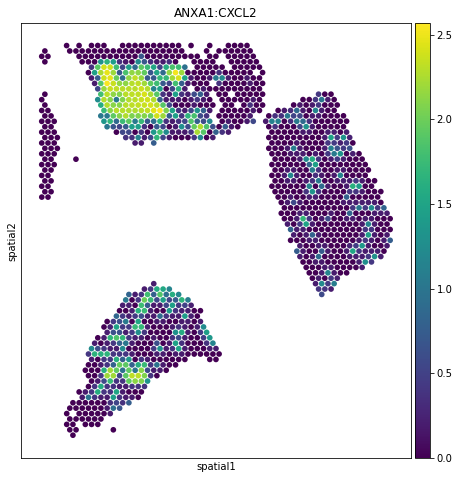

In [30]:
sc.pl.spatial(neighborhood_scores, img_key="hires", color=["ANXA1:CXCL2"], size = 1.4, alpha_img=0)

Specific pathway sets and De novo ligand-target clusters can be generated using the `create_cluster` function

> **Note**: pathways are to be provided in the format of a pandas dataframe with columns *'gs_name'*, *'gene_symbol'*

In [13]:
#Read in msgidb pathways
msigh = Renoir.get_msig('custom',path='/home/narein/msig_human_WP_H_KEGG.csv')
#Generate ligand-target sets for each pathway and/or De novo cluster
pathways = Renoir.create_cluster(neighborhood_scores, msigh, pathway_path='/home/narein/final_pathways.csv', use_pathway=True, method=None)
pathways.keys()

dict_keys(['HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'KEGG_JAK_STAT_SIGNALING_PATHWAY', 'KEGG_MAPK_SIGNALING_PATHWAY', 'KEGG_NEUROTROPHIN_SIGNALING_PATHWAY', 'KEGG_TGF_BETA_SIGNALING_PATHWAY', 'KEGG_WNT_SIGNALING_PATHWAY', 'WP_ERBB_SIGNALING_PATHWAY', 'WP_MAPK_SIGNALING_PATHWAY', 'WP_PI3KAKT_SIGNALING_PATHWAY', 'WP_TGFBETA_RECEPTOR_SIGNALING', 'WP_TGFBETA_SIGNALING_PATHWAY', 'WP_VEGFAVEGFR2_SIGNALING_PATHWAY', 'WP_WNT_SIGNALING'])

Communication domains and the spatial map of pathway activities can be generated using the neighborhood scores as so,

In [25]:
neighbscore_copy, pcs = Renoir.downstream_analysis(neighborhood_scores, ltpair_clusters=pathways, resolution=0.6, n_markers=20, n_top=20, pdf_path=None, return_cluster=True, return_pcs=True)

The communication domains and pathway activity can be visualized as follows,

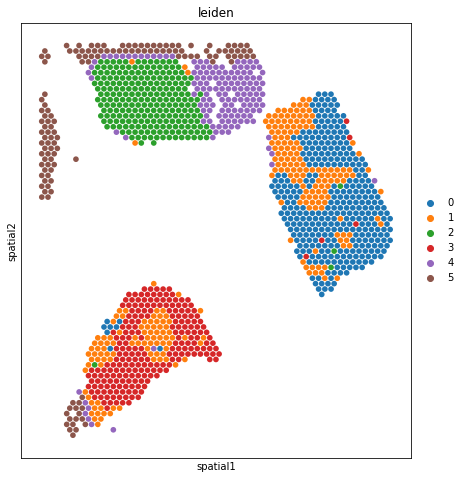

In [35]:
sc.pl.spatial(neighbscore_copy, img_key="hires", color=["leiden"], size=1.4, alpha_img=0)

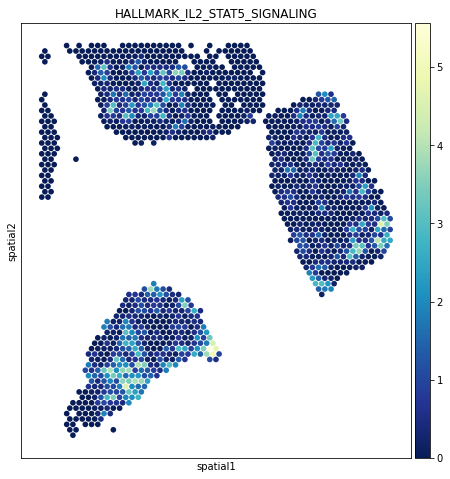

In [32]:
sc.pl.spatial(pcs, img_key="hires", color=["HALLMARK_IL2_STAT5_SIGNALING"], size = 1.4, alpha_img=0, cmap='YlGnBu_r')